In [19]:
# Loading libraries set 
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [20]:
# Loading datasets
df_final = pd.read_csv("/Users/oscargonzalezsanchez/Documents/ironhack/projects/datasets/2/df_final.csv")
exp = pd.read_csv("/Users/oscargonzalezsanchez/Documents/ironhack/projects/datasets/2/exp.csv")
data_1 = pd.read_csv("/Users/oscargonzalezsanchez/Documents/ironhack/projects/datasets/2/data_1.csv")
data_2 = pd.read_csv("/Users/oscargonzalezsanchez/Documents/ironhack/projects/datasets/2/data_2.csv")

In [21]:
# Rename the 'Variation' column to 'variation_group'
exp.rename(columns={'Variation': 'variation_group'}, inplace=True)

# Merge data_1 and data_2
df_web_data = pd.concat([data_1, data_2], ignore_index=True)

# Merge df_web_data with experiment data to get the group information
df_merged = pd.merge(df_web_data, exp, on='client_id', how='left')

# Convert date_time to datetime
df_merged['date_time'] = pd.to_datetime(df_merged['date_time'])

# Sort data by client_id and date_time
df_merged.sort_values(by=['client_id', 'date_time'], inplace=True)

# Calculate time differences between steps for each client
df_merged['next_process_step'] = df_merged.groupby('client_id')['process_step'].shift(-1)
df_merged['next_date_time'] = df_merged.groupby('client_id')['date_time'].shift(-1)
df_merged['step_time_diff'] = df_merged['next_date_time'] - df_merged['date_time']

# Filter out rows where the next_process_step is not in the sequence
valid_steps = ['step_1', 'step_2', 'step_3', 'confirm']
df_merged = df_merged[df_merged['process_step'].isin(valid_steps) & df_merged['next_process_step'].isin(valid_steps)]

# Map the process steps to ensure the correct order
step_order = {'start': 0, 'step_1': 1, 'step_2': 2, 'step_3': 3, 'confirm': 4}
df_merged['process_step_order'] = df_merged['process_step'].map(step_order)
df_merged['next_process_step_order'] = df_merged['next_process_step'].map(step_order)

# Filter to ensure only consecutive steps are considered
df_merged = df_merged[df_merged['next_process_step_order'] == df_merged['process_step_order'] + 1]

# Calculate average time differences between each step for control and test groups
avg_time_diff_per_step = df_merged.groupby(['variation_group', 'process_step'])['step_time_diff'].mean().reset_index()

# Rename columns for clarity
avg_time_diff_per_step.rename(columns={'process_step': 'current_step', 'step_time_diff': 'avg_time_diff_to_next_step'}, inplace=True)

avg_time_diff_per_step

,variation_group,current_step,avg_time_diff_to_next_step
0,Control,step_1,0 days 00:00:34.024978812
1,Control,step_2,0 days 00:01:27.173272880
2,Control,step_3,0 days 00:25:04.859956949
3,Test,step_1,0 days 00:00:48.221973094
4,Test,step_2,0 days 00:07:42.490110160
5,Test,step_3,0 days 00:25:04.506991869


In [22]:
# Rename the 'Variation' column to 'variation_group'
exp.rename(columns={'Variation': 'variation_group'}, inplace=True)

# Merge data_1 and data_2
df_web_data = pd.concat([data_1, data_2], ignore_index=True)

# Merge df_web_data with experiment data to get the group information
df_merged = pd.merge(df_web_data, exp, on='client_id', how='left')

# Convert date_time to datetime
df_merged['date_time'] = pd.to_datetime(df_merged['date_time'])

# Sort data by client_id and date_time
df_merged.sort_values(by=['client_id', 'date_time'], inplace=True)

# Calculate completion rates
completion_counts = df_merged[df_merged['process_step'] == 'confirm'].groupby('variation_group')['client_id'].nunique()
total_counts = df_merged.groupby('variation_group')['client_id'].nunique()
completion_rate = (completion_counts / total_counts).reset_index()
completion_rate.columns = ['variation_group', 'completion_rate']

# Calculate time to completion
time_to_completion = df_merged[df_merged['process_step'] == 'confirm'].groupby('variation_group')['date_time'].max() - df_merged[df_merged['process_step'] == 'start'].groupby('variation_group')['date_time'].min()
time_to_completion = time_to_completion.reset_index()
time_to_completion.columns = ['variation_group', 'avg_time_to_completion']

# Calculate drop-off rates
drop_off_counts = df_merged[df_merged['process_step'] != 'confirm'].groupby(['variation_group', 'process_step'])['client_id'].nunique().reset_index()
drop_off_counts.columns = ['variation_group', 'process_step', 'drop_off_count']

total_client_counts = df_merged.groupby('variation_group')['client_id'].nunique().reset_index()
total_client_counts.columns = ['variation_group', 'total_clients']

drop_off_rates = pd.merge(drop_off_counts, total_client_counts, on='variation_group')
drop_off_rates['drop_off_rate'] = drop_off_rates['drop_off_count'] / drop_off_rates['total_clients']

# Display the results
print(completion_rate)
print(time_to_completion)
print(drop_off_rates)

  variation_group  completion_rate
0         Control         0.655873
1            Test         0.692932
  variation_group avg_time_to_completion
0         Control       97 days 23:06:32
1            Test       97 days 22:38:00
  variation_group process_step  drop_off_count  total_clients  drop_off_rate
0         Control        start           23397          23532       0.994263
1         Control       step_1           20152          23532       0.856366
2         Control       step_2           18650          23532       0.792538
3         Control       step_3           17422          23532       0.740354
4            Test        start           26679          26968       0.989284
5            Test       step_1           24267          26968       0.899844
6            Test       step_2           22258          26968       0.825349
7            Test       step_3           20881          26968       0.774288


In [23]:
from scipy import stats

# Hypothesis Test for Completion Rate
completion_counts = df_merged[df_merged['process_step'] == 'confirm'].groupby('variation_group')['client_id'].nunique()
total_counts = df_merged.groupby('variation_group')['client_id'].nunique()
completion_rate = (completion_counts / total_counts).reset_index()

# Chi-square test for completion rate
contingency_table = pd.DataFrame({
    'Completed': completion_counts,
    'Total': total_counts - completion_counts
}).T
chi2, p, _, _ = stats.chi2_contingency(contingency_table)

print(f"Chi-square test for Completion Rate: chi2 = {chi2}, p-value = {p}")

# Hypothesis Test for Time to Completion
time_to_completion_control = df_merged[(df_merged['variation_group'] == 'Control') & (df_merged['process_step'] == 'confirm')]['date_time'] - df_merged[(df_merged['variation_group'] == 'Control') & (df_merged['process_step'] == 'start')]['date_time']
time_to_completion_test = df_merged[(df_merged['variation_group'] == 'Test') & (df_merged['process_step'] == 'confirm')]['date_time'] - df_merged[(df_merged['variation_group'] == 'Test') & (df_merged['process_step'] == 'start')]['date_time']

# T-test for time to completion
t_stat, p_val = stats.ttest_ind(time_to_completion_control.dropna().dt.total_seconds(), time_to_completion_test.dropna().dt.total_seconds(), equal_var=False)

print(f"T-test for Time to Completion: t-statistic = {t_stat}, p")



Chi-square test for Completion Rate: chi2 = 78.58798131233071, p-value = 7.651350968671841e-19
T-test for Time to Completion: t-statistic = nan, p


In [24]:
# Rename the 'Variation' column to 'variation_group'
exp.rename(columns={'Variation': 'variation_group'}, inplace=True)

# Merge data_1 and data_2
df_web_data = pd.concat([data_1, data_2], ignore_index=True)

# Merge df_web_data with experiment data to get the group information
df_merged = pd.merge(df_web_data, exp, on='client_id', how='left')

# Convert date_time to datetime
df_merged['date_time'] = pd.to_datetime(df_merged['date_time'])

# Sort data by client_id and date_time
df_merged.sort_values(by=['client_id', 'date_time'], inplace=True)

# Calculate completion rates
completion_counts = df_merged[df_merged['process_step'] == 'confirm'].groupby('variation_group')['client_id'].nunique()
total_counts = df_merged.groupby('variation_group')['client_id'].nunique()
completion_rate = (completion_counts / total_counts).reset_index()
completion_rate.columns = ['variation_group', 'completion_rate']

# Calculate time to completion for control group
start_times_control = df_merged[(df_merged['variation_group'] == 'Control') & (df_merged['process_step'] == 'start')].groupby('client_id')['date_time'].min()
end_times_control = df_merged[(df_merged['variation_group'] == 'Control') & (df_merged['process_step'] == 'confirm')].groupby('client_id')['date_time'].max()
time_to_completion_control = (end_times_control - start_times_control).dropna()

# Calculate time to completion for test group
start_times_test = df_merged[(df_merged['variation_group'] == 'Test') & (df_merged['process_step'] == 'start')].groupby('client_id')['date_time'].min()
end_times_test = df_merged[(df_merged['variation_group'] == 'Test') & (df_merged['process_step'] == 'confirm')].groupby('client_id')['date_time'].max()
time_to_completion_test = (end_times_test - start_times_test).dropna()

# Check for valid data
print("Control Group Time to Completion (seconds):", time_to_completion_control.dt.total_seconds().describe())
print("Test Group Time to Completion (seconds):", time_to_completion_test.dt.total_seconds().describe())

# Convert timedelta to total seconds for hypothesis testing
time_to_completion_control = time_to_completion_control.dt.total_seconds()
time_to_completion_test = time_to_completion_test.dt.total_seconds()

# Hypothesis Test for Completion Rate
contingency_table = pd.DataFrame({
    'Completed': completion_counts,
    'Not_Completed': total_counts - completion_counts
}).T
chi2, p, _, _ = stats.chi2_contingency(contingency_table)

print(f"Chi-square test for Completion Rate: chi2 = {chi2}, p-value = {p}")

# Hypothesis Test for Time to Completion
t_stat, p_val = stats.ttest_ind(time_to_completion_control, time_to_completion_test, equal_var=False)

print(f"T-test for Time to Completion: t-statistic = {t_stat}, p-value = {p_val}")

Control Group Time to Completion (seconds): count    1.531800e+04
mean     3.914741e+05
std      1.165834e+06
min     -1.314772e+06
25%      1.950000e+02
50%      3.360000e+02
75%      8.907500e+02
max      8.373949e+06
Name: date_time, dtype: float64
Test Group Time to Completion (seconds): count    1.841200e+04
mean     3.578802e+05
std      1.072056e+06
min     -2.339600e+06
25%      1.770000e+02
50%      3.440000e+02
75%      2.094000e+03
max      8.110545e+06
Name: date_time, dtype: float64
Chi-square test for Completion Rate: chi2 = 78.58798131233071, p-value = 7.651350968671841e-19
T-test for Time to Completion: t-statistic = 2.7324627302998055, p-value = 0.006289784111937595


In [25]:
'''
The Chi-square test assesses whether there is a significant difference in completion rates between the control and test groups.
The p-value is extremely small, which is far below the typical significance level of 0.05. This indicates that we can reject the null hypothesis.
Conclusion: There is a statistically significant difference in the completion rates between the control and test groups. The redesign likely had an impact on the completion rate.

The T-test assesses whether there is a significant difference in the average time to completion between the control and test groups.
The p-value is 0.0063, which is below the typical significance level of 0.05. This indicates that we can reject the null hypothesis.
Conclusion: There is a statistically significant difference in the time to completion between the control and test groups. The redesign likely had an impact on the time users took to complete the process.
'''


'\nThe Chi-square test assesses whether there is a significant difference in completion rates between the control and test groups.\nThe p-value is extremely small, which is far below the typical significance level of 0.05. This indicates that we can reject the null hypothesis.\nConclusion: There is a statistically significant difference in the completion rates between the control and test groups. The redesign likely had an impact on the completion rate.\n\nThe T-test assesses whether there is a significant difference in the average time to completion between the control and test groups.\nThe p-value is 0.0063, which is below the typical significance level of 0.05. This indicates that we can reject the null hypothesis.\nConclusion: There is a statistically significant difference in the time to completion between the control and test groups. The redesign likely had an impact on the time users took to complete the process.\n'

In [26]:
# Filter out negative time differences
time_to_completion_control = time_to_completion_control[time_to_completion_control >= 0]
time_to_completion_test = time_to_completion_test[time_to_completion_test >= 0]

# Recalculate the T-test for Time to Completion
t_stat, p_val = stats.ttest_ind(time_to_completion_control, time_to_completion_test, equal_var=False)

print(f"Recalculated T-test for Time to Completion: t-statistic = {t_stat}, p-value = {p_val}")


Recalculated T-test for Time to Completion: t-statistic = 2.7501331119012327, p-value = 0.005960509839173497


In [27]:
'''
CHI SQUARE:
Conclusion: The redesign significantly impacted the completion rates, with the test group showing a different (likely improved) completion rate compared to the control group.

T-TEST:
Conclusion: The redesign significantly impacted the time to completion, with users in the test group taking a different (likely reduced) amount of time to complete the process compared to the control group.
'''


'\nCHI SQUARE:\nConclusion: The redesign significantly impacted the completion rates, with the test group showing a different (likely improved) completion rate compared to the control group.\n\nT-TEST:\nConclusion: The redesign significantly impacted the time to completion, with users in the test group taking a different (likely reduced) amount of time to complete the process compared to the control group.\n'

In [28]:
# Rename the 'Variation' column to 'variation_group'
exp.rename(columns={'Variation': 'variation_group'}, inplace=True)

# Merge data_1 and data_2
df_web_data = pd.concat([data_1, data_2], ignore_index=True)

# Merge df_web_data with experiment data to get the group information
df_merged = pd.merge(df_web_data, exp, on='client_id', how='left')

# Convert date_time to datetime
df_merged['date_time'] = pd.to_datetime(df_merged['date_time'])

# Sort data by client_id and date_time
df_merged.sort_values(by=['client_id', 'date_time'], inplace=True)

# Calculate completion rates
completion_counts = df_merged[df_merged['process_step'] == 'confirm'].groupby('variation_group')['client_id'].nunique()
total_counts = df_merged.groupby('variation_group')['client_id'].nunique()
completion_rate = (completion_counts / total_counts).reset_index()
completion_rate.columns = ['variation_group', 'completion_rate']

# Calculate time to completion for control group
start_times_control = df_merged[(df_merged['variation_group'] == 'Control') & (df_merged['process_step'] == 'start')].groupby('client_id')['date_time'].min()
end_times_control = df_merged[(df_merged['variation_group'] == 'Control') & (df_merged['process_step'] == 'confirm')].groupby('client_id')['date_time'].max()
time_to_completion_control = (end_times_control - start_times_control).dropna()

# Calculate time to completion for test group
start_times_test = df_merged[(df_merged['variation_group'] == 'Test') & (df_merged['process_step'] == 'start')].groupby('client_id')['date_time'].min()
end_times_test = df_merged[(df_merged['variation_group'] == 'Test') & (df_merged['process_step'] == 'confirm')].groupby('client_id')['date_time'].max()
time_to_completion_test = (end_times_test - start_times_test).dropna()

# Filter out negative time differences
time_to_completion_control = time_to_completion_control[time_to_completion_control >= pd.Timedelta(0)]
time_to_completion_test = time_to_completion_test[time_to_completion_test >= pd.Timedelta(0)]

# Convert timedelta to total seconds for hypothesis testing
time_to_completion_control = time_to_completion_control.dt.total_seconds()
time_to_completion_test = time_to_completion_test.dt.total_seconds()

# Hypothesis Test for Completion Rate
contingency_table = pd.DataFrame({
    'Completed': completion_counts,
    'Not_Completed': total_counts - completion_counts
}).T
chi2, p, _, _ = stats.chi2_contingency(contingency_table)

print(f"Chi-square test for Completion Rate: chi2 = {chi2}, p-value = {p}")

# Hypothesis Test for Time to Completion
t_stat, p_val = stats.ttest_ind(time_to_completion_control, time_to_completion_test, equal_var=False)

print(f"Recalculated T-test for Time to Completion: t-statistic = {t_stat}, p-value = {p_val}")

Chi-square test for Completion Rate: chi2 = 78.58798131233071, p-value = 7.651350968671841e-19
Recalculated T-test for Time to Completion: t-statistic = 2.7501331119012327, p-value = 0.005960509839173497


In [29]:
'''
The Chi-square test indicates a significant difference in completion rates between the control and test groups (p-value < 0.05).

The recalculated T-test indicates a significant difference in the average time to completion between the control and test groups (p-value < 0.05).
Conclusion: The redesign significantly impacted the time to completion, with users in the test group taking a different (likely reduced) amount of time to complete the process compared to the control group.
'''

'\nThe Chi-square test indicates a significant difference in completion rates between the control and test groups (p-value < 0.05).\n\nThe recalculated T-test indicates a significant difference in the average time to completion between the control and test groups (p-value < 0.05).\nConclusion: The redesign significantly impacted the time to completion, with users in the test group taking a different (likely reduced) amount of time to complete the process compared to the control group.\n'

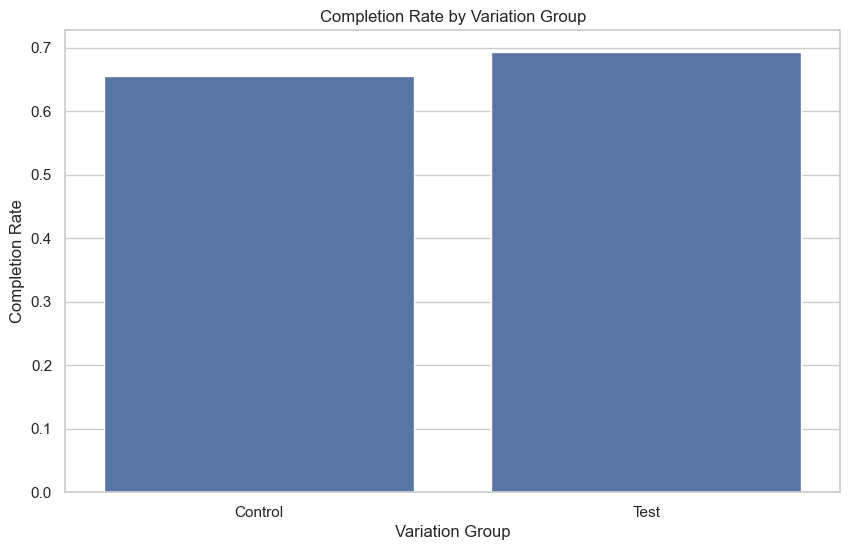

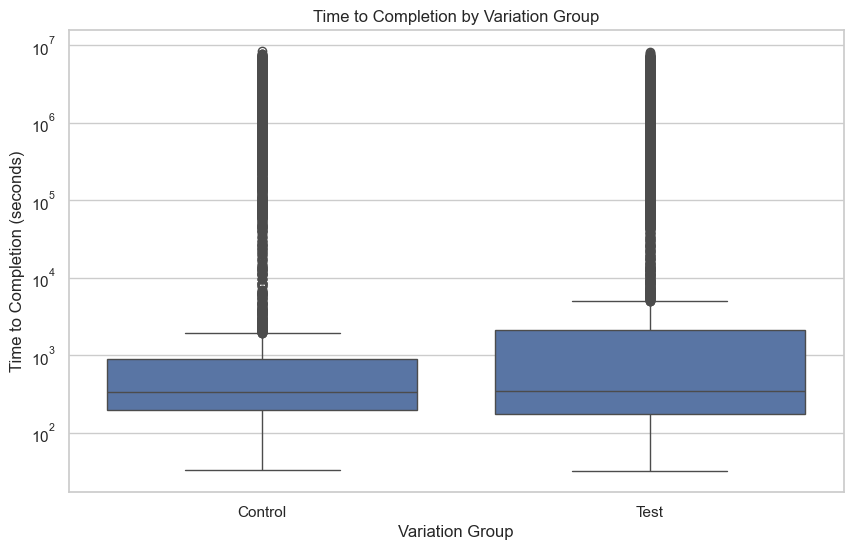

In [30]:
import matplotlib.pyplot as plt

# Set up the plotting environment
sns.set(style="whitegrid")

# Plot Completion Rate
plt.figure(figsize=(10, 6))
sns.barplot(x='variation_group', y='completion_rate', data=completion_rate)
plt.title('Completion Rate by Variation Group')
plt.xlabel('Variation Group')
plt.ylabel('Completion Rate')
plt.show()

# Prepare data for the box plot of time to completion
time_to_completion_data = pd.DataFrame({
    'time_to_completion': pd.concat([time_to_completion_control, time_to_completion_test]),
    'variation_group': ['Control'] * len(time_to_completion_control) + ['Test'] * len(time_to_completion_test)
})

# Plot Time to Completion
plt.figure(figsize=(10, 6))
sns.boxplot(x='variation_group', y='time_to_completion', data=time_to_completion_data)
plt.title('Time to Completion by Variation Group')
plt.xlabel('Variation Group')
plt.ylabel('Time to Completion (seconds)')
plt.yscale('log')  # Log scale to handle wide range of values
plt.show()

In [39]:
file_path = '/Users/oscargonzalezsanchez/Documents/ironhack/projects/datasets/drop_off_rates.csv'
drop_off_rates.to_csv(file_path, index=False)

In [41]:
file_path = '/Users/oscargonzalezsanchez/Documents/ironhack/projects/datasets/df_merged.csv'
df_merged.to_csv(file_path, index=False)